In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import torchvision.transforms as transforms
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_set = torchvision.datasets.FashionMNIST(root=".", train=True, download=True, transform=transform)

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

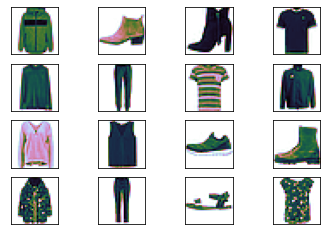

In [ ]:
real_samples, Fashionmnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28,28), cmap="cubehelix_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
discriminator = Discriminator().to(device=device)        

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
epochs = 100
loss_function = nn.BCELoss()

optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    for n, (real_samples, Fashionmnist_labels) in enumerate(train_loader):
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_dis = discriminator(all_samples)
        loss_dis = loss_function(output_dis, all_samples_labels)
        loss_dis.backward()
        optimizer_dis.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_g = loss_function(output_discriminator_generated, real_samples_labels)
        loss_g.backward()
        optimizer_g.step()

        # # Show loss
        # if n == batch_size - 1:
        #     print(f"Epoch: {epoch} Loss D.: {loss_dis}")
        #     print(f"Epoch: {epoch} Loss G.: {loss_g}")
        print('loss_dis', loss_dis.item())
        print('loss_g', loss_g.item())


In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

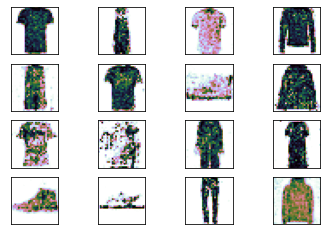

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="cubehelix_r")
    plt.xticks([])
    plt.yticks([])